### Get map assets
* OSM map features: https://wiki.openstreetmap.org/wiki/Map_features

In [1]:
# Packages
import osmnx as ox
import geopandas as gpd
import contextily as cx
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
import geoviews as gv
from shapely.geometry import box

In [2]:
# Functions
def buffer_aoi(gdf_aoi, buffer=1000):
    # Reproject to EPSG:3857
    crs = gdf_aoi.crs
    gdf_aoi = gdf_aoi.to_crs('EPSG:3857')

    # Buffer area of interest
    gdf_aoi['geometry'] = gdf_aoi.buffer(buffer)

    # Reproject back to original crs
    gdf_aoi = gdf_aoi.to_crs(crs)
    
    # Return buffered aoi
    return gdf_aoi

def features_from_aoi(gdf_aoi, tags, clip='false'):
    # Get bounds
    bounds = gdf_aoi.total_bounds

    # Get features from bbox
    try:
        gdf_features = ox.features_from_bbox(bounds, tags)
    except ox._errors.InsufficientResponseError:
        gdf_features = gpd.GeoDataFrame(columns=['geometry'], crs=gdf_aoi.crs)
    
    # Clip features to bbox
    if clip == 'aoi':
        gdf_features = gdf_features.clip(gdf_aoi)
    if clip == 'box':
        gdf_features = gdf_features.cx[bounds[0]:bounds[2], bounds[1]:bounds[3]]
        
    # Return features
    return gdf_features

In [3]:
# Define geographic area of interest
geocode_aoi = "Rotterdam, Netherlands"
#geocode_aoi = "Amsterdam, Netherlands"
#geocode_aoi = "London, United Kingdom"
#geocode_aoi = "Berlin, Germany"
#geocode_aoi = "Munich, Germany"
#geocode_aoi = "Istanbul, Turkey"
#geocode_aoi = "Dubai, United Arab Emirates"

# Get area of interest
gdf_aoi = ox.geocode_to_gdf(geocode_aoi)
#gdf_aoi = gpd.GeoDataFrame(data={'geometry': [box(4.3, 51.92, 4.7, 51.94)], 'name': ['bbox']}, crs=gdf_aoi.crs)
#gdf_aoi = gpd.GeoDataFrame(data={'geometry': [box(4.45, 51.86, 4.50, 52.0)], 'name': ['bbox']}, crs=gdf_aoi.crs)

# Get buffered area of interest
gdf_buffer = buffer_aoi(gdf_aoi, buffer=500)

# Get bounding box
gdf_bbox = gpd.GeoDataFrame(data={'geometry': [box(*gdf_buffer.total_bounds)], 'name': ['bbox']}, crs=gdf_buffer.crs)

# Get bounds, centre, width and height
bounds = gdf_bbox.total_bounds
centre = (bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2
width = (bounds[2] - bounds[0])
height = bounds[3] - bounds[1]

# Get aspect ratio from plot
fig, ax = plt.subplots(figsize=(width/100, height/100))
gdf_buffer.boundary.plot(ax=ax)
aspect_ratio = ax.get_aspect()
plt.close(fig)

# Adjust width and height based on aspect ratio to fit onto A4 paper
if width > height:
    if width < height * aspect_ratio * np.sqrt(2):
         width = height * aspect_ratio * np.sqrt(2) 
    else:
        height = width / aspect_ratio / np.sqrt(2)
elif height > width:
    if height < width / aspect_ratio * np.sqrt(2):
         height = width / aspect_ratio * np.sqrt(2) 
    else:
        width = height * aspect_ratio / np.sqrt(2)
bounds = centre[1] - width / 2, centre[0] - height / 2, centre[1] + width / 2, centre[0] + height / 2
gdf_bbox = gpd.GeoDataFrame(data={'geometry': [box(*bounds)], 'name': ['bbox']}, crs=gdf_bbox.crs)

# Get limits
bounds = gdf_bbox.total_bounds
xlim = (bounds[0], bounds[2])
ylim = (bounds[1], bounds[3])

# Get suburbs
gdf_suburbs = features_from_aoi(gdf_bbox, tags={"place": "suburb"})
gdf_suburbs = gdf_suburbs.clip(gdf_aoi)
gdf_suburbs = gdf_suburbs[np.logical_or(gdf_suburbs.geom_type == "Polygon", gdf_suburbs.geom_type == "MultiPolygon")]

# Get train lines
gdf_train_lines = features_from_aoi(gdf_bbox, tags={"railway": "rail"})
if "usage"  in gdf_train_lines.columns:
    gdf_train_lines = gdf_train_lines[gdf_train_lines["usage"].isin(["main", "branch"])]

# Get metro lines
gdf_metro_lines = features_from_aoi(gdf_bbox, tags={"railway": "subway"})
if "service" in gdf_metro_lines.columns:
    gdf_metro_lines = gdf_metro_lines[~gdf_metro_lines["service"].isin(["yard", "siding", "spur", "crossover"])]

# Get light rail lines
gdf_light_rail_lines = features_from_aoi(gdf_bbox, tags={"railway": "light_rail"})

# Get tram lines
gdf_tram_lines = features_from_aoi(gdf_bbox, tags={"railway": "tram"})
if "service" in gdf_tram_lines.columns:
    gdf_tram_lines = gdf_tram_lines[~gdf_tram_lines["service"].isin(["yard", "siding", "spur", "crossover"])]

# Get train, metro, light rail stations
gdf_stations = features_from_aoi(gdf_bbox, tags={"railway": "station"})
gdf_stations["geometry"] = gdf_stations["geometry"].map(lambda x: x.centroid if x.geom_type != "Point" and x.geom_type != "MultiPoint" else x)
if "station" in gdf_stations.columns:
    gdf_train_stations = gdf_stations[~gdf_stations["station"].isin(["subway", "light_rail"])]
    gdf_metro_stations = gdf_stations[gdf_stations["station"].isin(["subway"])]
    gdf_light_rail_stations = gdf_stations[gdf_stations["station"].isin(["light_rail"])]
    gdf_tram_stations = gdf_stations[gdf_stations["station"].isin(["tram"])]

# Get tram stations
gdf_tram_stations = features_from_aoi(gdf_bbox, tags={"railway": "tram_stop"})
gdf_tram_stations["geometry"] = gdf_tram_stations["geometry"].map(lambda x: x.centroid if x.geom_type != "Point" else x)

# Remove museum tramstation amsterdam
#gdf_tram_stations = gdf_tram_stations[gdf_tram_stations["wikidata"].notna()] 

In [4]:
# Keep name and geometry
gdf_aoi = gdf_aoi[["name", "geometry"]].reset_index(drop=True)
gdf_buffer = gdf_buffer[["name", "geometry"]].reset_index(drop=True)
gdf_bbox = gdf_bbox[["name", "geometry"]].reset_index(drop=True)
gdf_suburbs = gdf_suburbs[["name", "geometry"]].reset_index(drop=True)
gdf_train_stations = gdf_train_stations[["name", "geometry"]].reset_index(drop=True)
gdf_metro_stations = gdf_metro_stations[["name", "geometry"]].reset_index(drop=True)
gdf_light_rail_stations = gdf_light_rail_stations[["name", "geometry"]].reset_index(drop=True)
gdf_tram_stations = gdf_tram_stations[["name", "geometry"]].reset_index(drop=True)
gdf_train_lines = gdf_train_lines[["name", "geometry"]].reset_index(drop=True)
gdf_metro_lines = gdf_metro_lines[["name", "geometry"]].reset_index(drop=True)
gdf_light_rail_lines = gdf_light_rail_lines[["name", "geometry"]].reset_index(drop=True)
gdf_tram_lines = gdf_tram_lines[["name", "geometry"]].reset_index(drop=True)

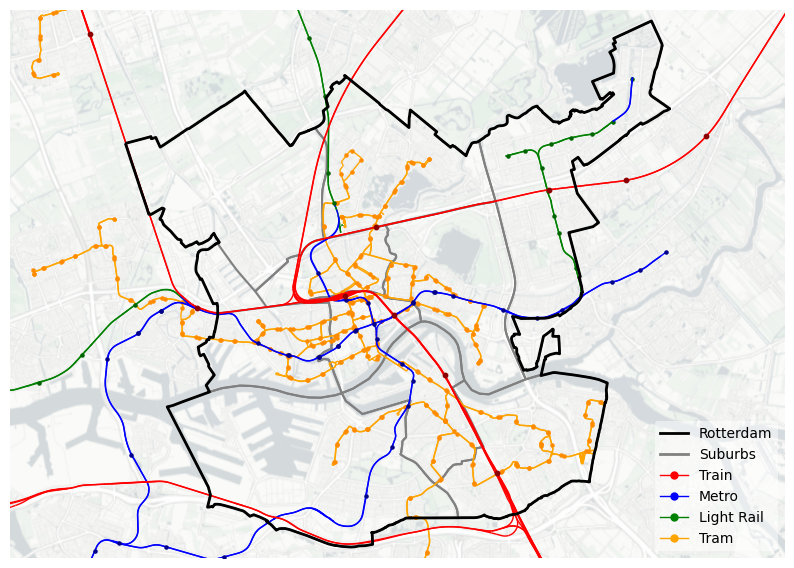

In [6]:
# Create figure
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Play area and suburbs
gdf_aoi.plot(ax=ax, facecolor='none', edgecolor="black", linewidth=2, zorder=3)
gdf_suburbs.plot(ax=ax, facecolor='none', edgecolor="grey", linewidth=1.5, linestyle='-', zorder=1)

# Plot buffered area of interest and bounding box
#gdf_buffer.plot(ax=ax, facecolor='none', edgecolor="blue", linewidth=2, linestyle='--', label="Buffer", zorder=2)
#gdf_bbox.plot(ax=ax, facecolor='none', edgecolor="black", linewidth=2, linestyle='-', label="Bounding Box", zorder=1)


# Plot train, metro, light rail, tram lines
if not gdf_train_stations.empty:
    gdf_train_lines.plot(ax=ax, color="red", linewidth=1, zorder=1.4)
if not gdf_metro_lines.empty:
    gdf_metro_lines.plot(ax=ax, color="blue", linewidth=1, zorder=1.3)
if not gdf_light_rail_lines.empty:
    gdf_light_rail_lines.plot(ax=ax, color="green", linewidth=1, zorder=1.2)
if not gdf_tram_lines.empty:
    gdf_tram_lines.plot(ax=ax, color="orange", linewidth=1, zorder=1.1)

# Plot train, metro, light rail, tram stations
if not gdf_train_stations.empty:
    gdf_train_stations.plot(ax=ax, color="darkred", markersize=10, zorder=1.4)
if not gdf_metro_stations.empty:
    gdf_metro_stations.plot(ax=ax, color="darkblue", markersize=5, zorder=1.3)
if not gdf_light_rail_stations.empty:
    gdf_light_rail_stations.plot(ax=ax, color="darkgreen", markersize=5, zorder=1.2)
if not gdf_tram_stations.empty:
    gdf_tram_stations.plot(ax=ax, color="darkorange", markersize=5, zorder=1.1)

# Add basemap
cx.add_basemap(ax, crs=gdf_train_lines.crs, source=cx.providers.CartoDB.PositronNoLabels, attribution=False, zoom=12)

# Add legend
ax.plot(np.nan, np.nan, color="black", linewidth=2, linestyle='-', label="{}".format(geocode_aoi.split(",")[0]))
ax.plot(np.nan, np.nan, color="grey", linewidth=2, linestyle='-', label="Suburbs")
ax.plot(np.nan, np.nan, color="red", linewidth=1, marker='o', markersize=5, label="Train")
ax.plot(np.nan, np.nan, color="blue", linewidth=1, marker='o', markersize=5, label="Metro")
ax.plot(np.nan, np.nan, color="green", linewidth=1, marker='o', markersize=5, label="Light Rail")
ax.plot(np.nan, np.nan, color="orange", linewidth=1, marker='o', markersize=5, label="Tram")
ax.legend(loc='lower right', facecolor=[1, 1, 1, 1], edgecolor='none', framealpha=0.5)

# Set limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_axis_off()
aspect = ax.get_aspect()

# Save figure
fig.savefig("map.png", bbox_inches='tight', pad_inches=0)
plt.show()

In [7]:
# Plot all lines and stations
plot_map = gv.tile_sources.CartoLight
plot_aoi = gdf_aoi.hvplot(geo=True, line_width=3, line_color="black", fill_color="none")
plot_suburbs = gdf_suburbs.hvplot(geo=True, line_width=2, line_color="grey", fill_color="none")

plot_train_lines = gdf_train_lines.hvplot(geo=True, line_width=2, line_color="red")
plot_metro_lines = gdf_metro_lines.hvplot(geo=True, line_width=2, line_color="blue")
plot_light_rail_lines = gdf_light_rail_lines.hvplot(geo=True, line_width=2, line_color="green")
plot_tram_lines = gdf_tram_lines.hvplot(geo=True, line_width=2, line_color="orange")

plot_train_stations = gdf_train_stations.hvplot(geo=True, color="darkred", size=20)
plot_metro_stations = gdf_metro_stations.hvplot(geo=True, color="darkblue", size=20)
plot_light_rail_stations = gdf_light_rail_stations.hvplot(geo=True, color="darkgreen", size=20)
plot_tram_stations = gdf_tram_stations.hvplot(geo=True, color="darkorange", size=20)

(plot_map * plot_suburbs * plot_tram_lines * plot_tram_stations * plot_light_rail_lines * plot_light_rail_stations *
 plot_metro_lines * plot_metro_stations * plot_train_lines * plot_train_stations * plot_aoi).opts(width=800, height=800)

:Overlay
   .WMTS.I      :WMTS   [Longitude,Latitude]
   .Polygons.I  :Polygons   [Longitude,Latitude]
   .Path.I      :Path   [Longitude,Latitude]
   .Points.I    :Points   [Longitude,Latitude]
   .Path.II     :Path   [Longitude,Latitude]
   .Points.II   :Points   [Longitude,Latitude]
   .Path.III    :Path   [Longitude,Latitude]
   .Points.III  :Points   [Longitude,Latitude]
   .Path.IV     :Path   [Longitude,Latitude]
   .Points.IV   :Points   [Longitude,Latitude]
   .Polygons.II :Polygons   [Longitude,Latitude]

In [186]:
# Write geojsons
gdf_aoi.to_file("../assets/map_aoi.geojson", driver="GeoJSON")
gdf_suburbs.to_file("../assets/map_suburbs.geojson", driver="GeoJSON")
gdf_train_lines.to_file("../assets/map_train_lines.geojson", driver="GeoJSON")
gdf_metro_lines.to_file("../assets/map_metro_lines.geojson", driver="GeoJSON")
gdf_light_rail_lines.to_file("../assets/map_light_rail_lines.geojson", driver="GeoJSON")
gdf_tram_lines.to_file("../assets/map_tram_lines.geojson", driver="GeoJSON")
gdf_train_stations.to_file("../assets/map_train_stations.geojson", driver="GeoJSON")
gdf_metro_stations.to_file("../assets/map_metro_stations.geojson", driver="GeoJSON")
gdf_light_rail_stations.to_file("../assets/map_light_rail_stations.geojson", driver="GeoJSON")
gdf_tram_stations.to_file("../assets/map_tram_stations.geojson", driver="GeoJSON")